In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
import math

Đọc dữ liệu

In [2]:
btc_data = pd.read_csv('BTC-USD.csv')
exog_data = pd.read_csv('BNB-USD.csv')

Dữ liệu BTC-USD

In [3]:
btc_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/1/2019,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4.324201e+09
1,1/2/2019,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5.244857e+09
2,1/3/2019,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4.530215e+09
3,1/4/2019,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4.847965e+09
4,1/5/2019,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5.137610e+09


Dữ liệu BNB-USD

In [4]:
exog_data.head()

,Date,Close-Exog
0,1/1/2019,6.075273
1,1/2/2019,6.188613
2,1/3/2019,5.903535
3,1/4/2019,6.065138
4,1/5/2019,6.065543


Kết hợp dữ liệu BTC và BNB

In [5]:
data = pd.merge(btc_data, exog_data, on='Date')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Close-Exog
0,1/1/2019,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4.324201e+09,6.075273
1,1/2/2019,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5.244857e+09,6.188613
2,1/3/2019,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4.530215e+09,5.903535
3,1/4/2019,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4.847965e+09,6.065138
4,1/5/2019,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5.137610e+09,6.065543


**Dự đoán 30 ngày cho BNB bằng ARIMA**

In [6]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.2 MB/s eta 0:00:00


In [7]:
eth_data = exog_data[['Date', 'Close-Exog']]
eth_data = exog_data.dropna() # Drop missing values
# eth_data = eth_data.reset_index(drop=True) # Reset the index
eth_data['Date'] = pd.to_datetime(eth_data['Date'])
eth_data.set_index('Date', inplace=True)

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(eth_data))
test_size = int(0.2 * len(eth_data))
val_size = len(eth_data) - train_size - test_size

train_data = eth_data[:train_size]
test_data = eth_data[train_size:train_size+test_size]
val_data = eth_data[train_size+test_size:]
print(eth_data)

            Close-Exog
Date                  
2019-01-01    6.075273
2019-01-02    6.188613
2019-01-03    5.903535
2019-01-04    6.065138
2019-01-05    6.065543
...                ...
2023-03-27  310.949127
2023-03-28  313.260620
2023-03-29  313.841766
2023-03-30  316.567566
2023-03-31  317.040009

[1551 rows x 1 columns]


In [8]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close-Exog'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8861.886, Time=3.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8905.891, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8881.960, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8885.892, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8905.033, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8875.774, Time=1.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8877.807, Time=1.89 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=8862.449, Time=7.01 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=8876.520, Time=5.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8878.596, Time=1.51 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8876.833, Time=4.37 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=8878.858, Time=3.74 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=8851.727, Time=8.98 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=8849.981, Time=10.21 sec
 ARIMA(4,1,2)(0,0,0)[0] intercep

ARIMA(order=(3, 1, 4), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [9]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close-Exog'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close-Exog'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [10]:
import datetime
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  eth_data.index[-1]
print(last_index)
next_30_days_index_eth = pd.date_range(start=last_index + datetime.timedelta(days=1), periods=30, freq='D')
print(next_30_days_index_eth)
# Create an array of 30 consecutive integers starting from last_index
x_next_30_days_eth = np.array(next_30_days_index_eth).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days_eth = model.predict(n_periods=len(x_next_30_days_eth)) 

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days_eth)

2023-03-31 00:00:00
DatetimeIndex(['2023-04-01', '2023-04-02', '2023-04-03', '2023-04-04',
               '2023-04-05', '2023-04-06', '2023-04-07', '2023-04-08',
               '2023-04-09', '2023-04-10', '2023-04-11', '2023-04-12',
               '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16',
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-22', '2023-04-23', '2023-04-24',
               '2023-04-25', '2023-04-26', '2023-04-27', '2023-04-28',
               '2023-04-29', '2023-04-30'],
              dtype='datetime64[ns]', freq='D')
Predicted closing prices for the next 30 days:
[532.2459854  532.03753686 525.54816074 527.9659898  532.69919062
 528.10607371 526.75418057 530.78065489 530.28925765 527.04670967
 529.09313125 530.64902998 528.39077659 528.07269931 530.119909
 529.38321132 528.10949918 529.24917293 529.79186114 528.59508095
 528.72314484 529.61707192 529.11871758 528.61112038 529.25578085
 529.36503244 52

Validation RMSE: 236.2426671244934
Testing RMSE: 205.45821136353726
Validation MAPE: 0.8131696460147575
Testing MAPE: 0.6437663918203378


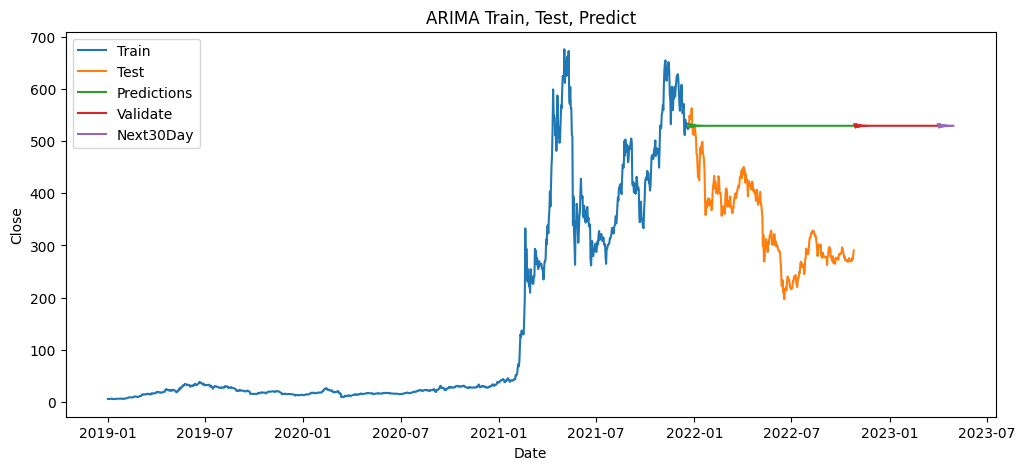

In [11]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_mape = np.mean(np.abs(y_pred_val - y_val)/np.abs(y_val))  # MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))  # MAPE
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
# 9.Vẽ hình
plt.figure(figsize=(12,5), dpi=100)
plt.ylabel('Close');
plt.xlabel('Date');
plt.title('ARIMA Train, Test, Predict')
plt.plot(train_data.index, train_data['Close-Exog'])
plt.plot(test_data.index, test_data['Close-Exog'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
# plt.plot(last_data,y_next_30_days)
plt.plot(next_30_days_index_eth,y_next_30_days_eth)

plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

**<h3>Dự đoán ARIMAX 7-2-1</h3>**

In [12]:

# data = data.reset_index(drop=True) # Reset the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Close', 'Close-Exog']]
data = data.dropna() # Drop missing values

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]
print(len(train_data))
print(len(test_data))
print(len(val_data))

1085
310
156


In [13]:
from pmdarima.arima import auto_arima
train_exog = train_data[["Close-Exog"]]
model = auto_arima(train_data.Close, 
                      test='adf',       # use adftest to find      
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,  
                      stepwise=True,
                      exogenous= train_exog)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=18326.915, Time=2.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18334.592, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18334.396, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18334.415, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18333.913, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=18338.414, Time=0.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=18338.402, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=18328.615, Time=4.45 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=18328.727, Time=6.85 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=18336.402, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=18339.506, Time=2.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=18339.964, Time=2.53 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=7.73 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=18338.278, Time=1.73 sec

Best model:  ARIMA(2,1,2

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(train_data.Close, 
 exog=train_exog,
 order=(2,1,2),
 enforce_invertibility=False, enforce_stationarity=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [15]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
test_exog = test_data[['Close-Exog']]
model_fit = model.fit()
# y_pred = model.predict(n_periods=len(y_test))
y_pred = model_fit.forecast(steps=len(y_test), exog=test_exog)
print(y_pred)

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
val_exog = val_data[['Close-Exog']]
print(val_exog)
y_pred_val =  model_fit.forecast(steps=len(y_val), exog=val_exog)
print(y_pred_val)

2021-12-21    47273.606536
2021-12-22    47251.736636
2021-12-23    47738.435245
2021-12-24    47540.768804
2021-12-25    48101.393842
                  ...     
2022-10-22    34500.725495
2022-10-23    34768.404262
2022-10-24    34670.271337
2022-10-25    35177.408362
2022-10-26    35465.434630
Freq: D, Name: predicted_mean, Length: 310, dtype: float64
            Close-Exog
Date                  
2022-10-27  286.844116
2022-10-28  298.014191
2022-10-29  304.217957
2022-10-30  313.754791
2022-10-31  326.360718
...                ...
2023-03-27  310.949127
2023-03-28  313.260620
2023-03-29  313.841766
2023-03-30  316.567566
2023-03-31  317.040009

[156 rows x 1 columns]
2021-12-21    35551.029788
2021-12-22    35831.406097
2021-12-23    35887.857476
2021-12-24    36483.142430
2021-12-25    37391.844953
                  ...     
2022-05-21    36468.453798
2022-05-22    36583.817564
2022-05-23    36601.099747
2022-05-24    36724.804366
2022-05-25    36754.102811
Freq: D, Name: predicted

In [16]:
import datetime
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  data.index[-1]
print(last_index)
# last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
next_30_days_index = pd.date_range(start=last_index + datetime.timedelta(days=1), periods=30, freq='D')
print(next_30_days_index)
# Create an array of 30 consecutive integers starting from last_index
# x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
x_next_30_days = np.array(next_30_days_index).reshape(-1, 1)



# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.forecast(steps=len(x_next_30_days), exog = y_next_30_days_eth) 

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

2023-03-31 00:00:00
DatetimeIndex(['2023-04-01', '2023-04-02', '2023-04-03', '2023-04-04',
               '2023-04-05', '2023-04-06', '2023-04-07', '2023-04-08',
               '2023-04-09', '2023-04-10', '2023-04-11', '2023-04-12',
               '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16',
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-22', '2023-04-23', '2023-04-24',
               '2023-04-25', '2023-04-26', '2023-04-27', '2023-04-28',
               '2023-04-29', '2023-04-30'],
              dtype='datetime64[ns]', freq='D')
Predicted closing prices for the next 30 days:
2021-12-21    47444.936934
2021-12-22    47173.829659
2021-12-23    46615.081756
2021-12-24    46865.329470
2021-12-25    47392.464101
2021-12-26    47184.994554
2021-12-27    46841.481475
2021-12-28    46888.950308
2021-12-29    47060.720382
2021-12-30    47138.750030
2021-12-31    47163.215251
2022-01-01    46977.505990
2022-01-02    46814.

In [17]:
# 12. Đánh giá độ chính xác thuật toán
import sklearn.metrics as metrics
mae = mean_absolute_error(y_test,y_pred)
print('Testing MAE: ', mae)
mae = mean_absolute_error(y_val,y_pred_val)
print('Validation MAE: ', mae)


Testing MAE:  7413.917614895819
Validation MAE:  15050.550959018463


In [18]:
mse = mean_squared_error(y_test,y_pred)
print('Testing MSE: ', mse)
mse = mean_squared_error(y_val,y_pred_val)
print('Validation MSE: ', mse)

Testing MSE:  88608482.69052672
Validation MSE:  234637512.23969063


In [19]:
rmse = math.sqrt(mean_squared_error(y_test,y_pred))
print('Testing RMSE: ', rmse)
rmse = math.sqrt(mean_squared_error(y_val, y_pred_val))
print('Validation RMSE: ', rmse)

Testing RMSE:  9413.207885228432
Validation RMSE:  15317.882106860943


In [20]:
r2 = r2_score(y_test, y_pred)
print('Testing R-Square:', r2)
r2 = r2_score(y_val, y_pred_val)
print('Validation R-Square: ', r2)

Testing R-Square: 0.1454070359627525
Validation R-Square:  -16.452154892520422


In [21]:
mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))
print('Testing MAPE: ', mape)
mape = np.mean(np.abs(y_pred_val - y_val)/np.abs(y_val))
print('Validation MAPE: ', mape)

Testing MAPE:  0.3309746770644736
Validation MAPE:  0.775573682884175


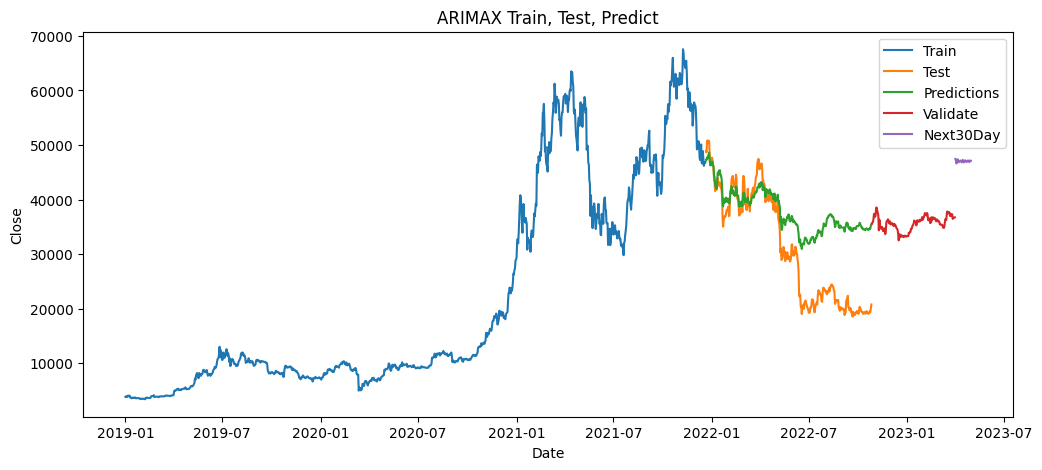

In [22]:
# 9.Vẽ hình
plt.figure(figsize=(12,5), dpi=100)
plt.ylabel('Close');
plt.xlabel('Date');
plt.title('ARIMAX Train, Test, Predict')
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(next_30_days_index,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()